# AIGC sentiment affiliation
This expirement is for checking the emotional bias of the content generated by AI

python version:3.10.14

In [1]:
import pandas as pd
import ollama
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from scipy.stats import mannwhitneyu
def Mann_Whitney_U_test(srs1:pd.Series, srs2:pd.Series):
    '''Perform the Mann-Whitney U-test'''
    u_statistic, p_value = mannwhitneyu(srs1, srs2, alternative='less')
    if p_value < 0.05:
        print(f"U-statis: {u_statistic}, P-value: {p_value}", end=', ')
        print('前者整体显著比后者小。')
        return
    
    u_statistic, p_value = mannwhitneyu(srs1, srs2, alternative='greater')
    if p_value < 0.05:
        print(f"U统计量: {u_statistic}, P值: {p_value}", end=', ')
        print('前者整体显著比后者大。')
        return
    
    u_statistic, p_value = mannwhitneyu(srs1, srs2, alternative='two-sided')
    print(f"U统计量: {u_statistic}, P值: {p_value}", end=', ')
    if p_value < 0.05:
        print('两组数据之间存在显著差异。')
    else:
        print('两组数据之间没有显著差异。')


from scipy.stats import ttest_ind
def t_test(srs1:pd.Series, srs2:pd.Series):
    '''Perform the T-test'''
    t_statistic, p_value = ttest_ind(srs1, srs2)
    print(f"T统计量: {t_statistic}, P值: {p_value}", end=', ')
    if p_value < 0.05:
        if t_statistic > 0:
            print('前者平均值显著比后者的大。')
        else:
            print('前者平均值显著比后者的小。')
    else:
        print('两组数据之间没有显著差异。')


# Reddit

In [2]:
Reddit = pd.read_csv("data/Reddit[topic=climatechange][model:gemma2+llama3]_[task:expand+response]_latest.csv")
Reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_utc             10900 non-null  object 
 1   author                  10900 non-null  object 
 2   subreddit               10900 non-null  object 
 3   body                    10900 non-null  object 
 4   parent_id               10897 non-null  object 
 5   subreddit_id            10897 non-null  object 
 6   id                      10897 non-null  object 
 7   lang                    290 non-null    object 
 8   gemma2 expand           10900 non-null  object 
 9   label[orginal text]     10900 non-null  object 
 10  score[orginal text]     10900 non-null  float64
 11  label[gemma2 expand]    10900 non-null  object 
 12  score[gemma2 expand]    10900 non-null  float64
 13  orginal_label           10900 non-null  object 
 14  orginal_score           10900 non-null

In [ ]:
Reddit.to_csv("data/Reddit_fulldata_forembedding.csv", index=False)

## 1. Gemma

### 1.1 *Heatmap plot*

/tmp/ipykernel_975774/2674008368.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


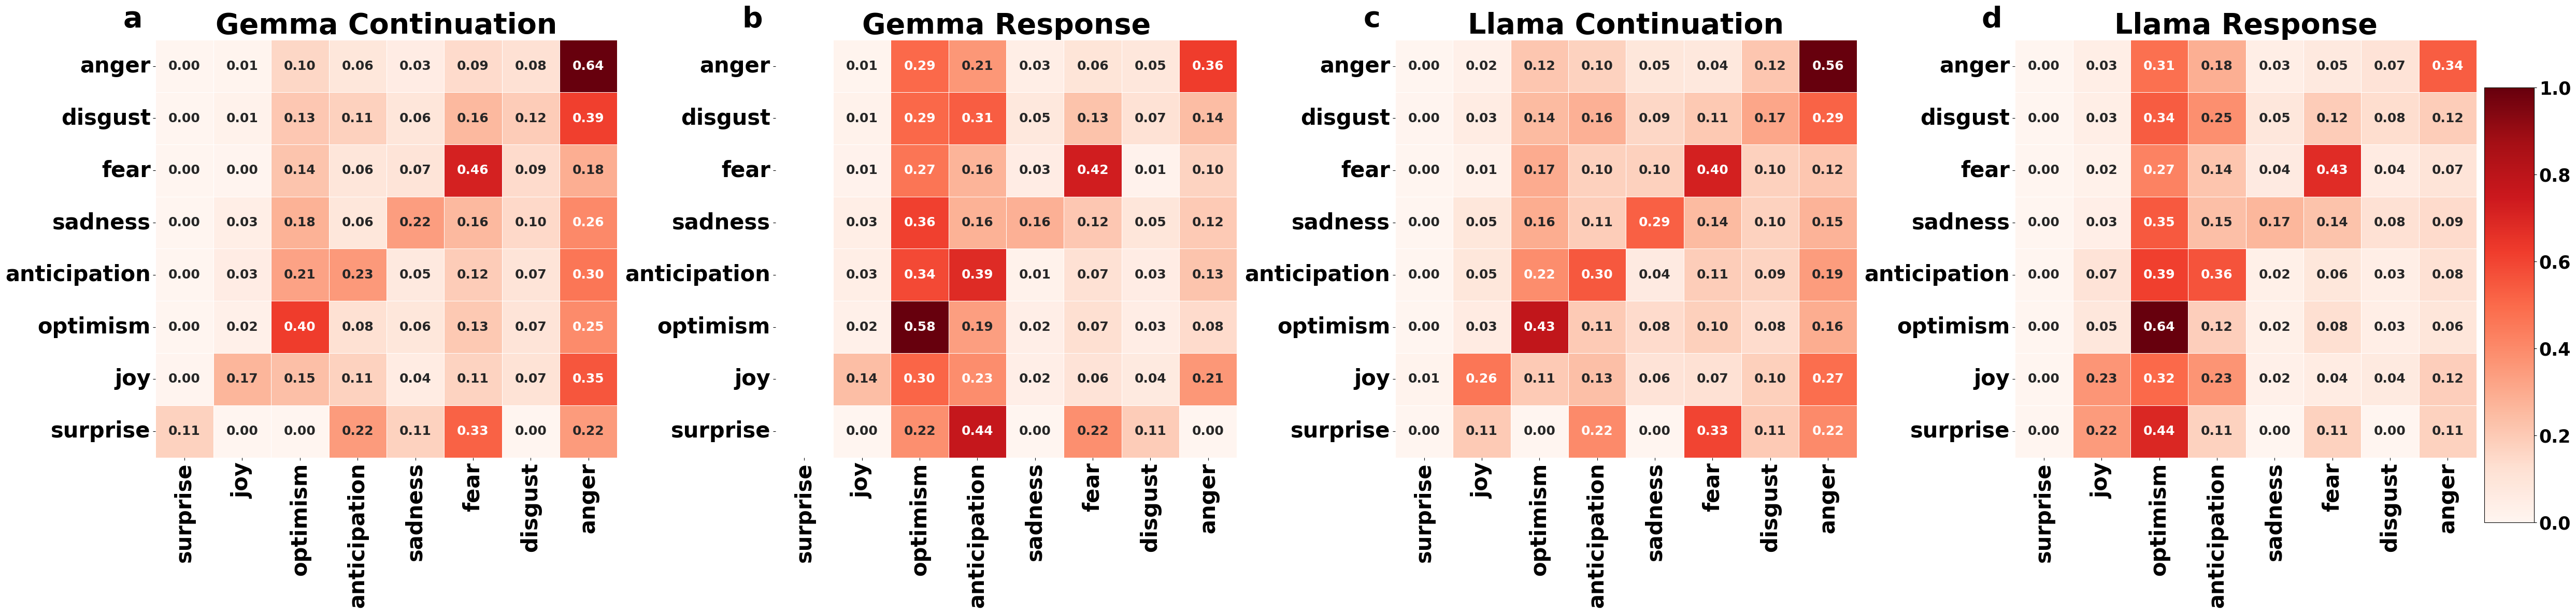

In [10]:
import numpy as np
# subplots
columns = ["[gemma]expand_label", "[gemma]response_label", "[llama3]expand_label", "[llama3]response_label"]
titles = ["Gemma Continuation", "Gemma Response", "Llama Continuation", "Llama Response"]
vmin = 0 
vmax = 1
sub_labels = ['a', 'b', 'c', 'd'] 

df = Reddit
fig, axes = plt.subplots(1, 4, figsize=(48, 12))
axes = axes.flatten()

for i, col in enumerate(columns):
    transition_matrix = pd.crosstab(
        df["orginal_label"], 
        df[col],
        rownames=["Original"],
        colnames=[col]
    )
    transition_matrix_normalized = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    emotions_order = ['anger', 'disgust', 'fear', 'sadness', 'anticipation', 'optimism', 'joy', 'surprise']
    #actual_emotions = transition_matrix_normalized.index.intersection(emotions_order)
    transition_matrix_normalized_2 = transition_matrix_normalized.reindex(index=emotions_order)

    change_column = ['surprise', 'joy','optimism','anticipation','sadness','fear','disgust','anger']
    #change_column = transition_matrix_normalized.columns.intersection(change_column)
    transition_matrix_normalized_2 = transition_matrix_normalized_2.reindex(columns = change_column)
 
    sns.heatmap(
        transition_matrix_normalized_2, 
        annot=True, 
        fmt=".2f", 
        cmap="Reds", 
        cbar=False,  
        ax=axes[i], 
        linewidths=0.5,
        annot_kws={"size": 18, "weight": "bold"}
    )
    
    axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=30,fontweight = 'bold', rotation = 90)  
    axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=30,fontweight = 'bold', rotation = 0)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    # title
    axes[i].set_title(f"{titles[i]}",fontweight = 'bold', fontsize=40)

    
    axes[i].annotate(
        sub_labels[i], 
        xy=(-0.05, 1.05), 
        xycoords='axes fraction', 
        fontsize=40, 
        fontweight='bold', 
        ha='center', 
        va='center'
    )
    

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # colorbar position（left, down, width, height）
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=25)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')
#cbar.set_label("Degree of Intensity") 

plt.tight_layout()
plt.savefig("new_pic/heatmap[Reddit][2models]_normalized_v4.png", dpi = 300, bbox_inches='tight')
plt.savefig("new_pic/heatmap[Reddit][2models]_normalized.pdf", dpi = 300, bbox_inches='tight' )
plt.show()

### 1.2 *Treemap*

In [37]:
Twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               12200 non-null  int64  
 1   conversation_id                  12200 non-null  float64
 2   referenced_tweets.replied_to.id  9831 non-null   float64
 3   author_id                        12200 non-null  int64  
 4   in_reply_to_user_id              9831 non-null   float64
 5   in_reply_to_username             3473 non-null   object 
 6   text                             12200 non-null  object 
 7   author.username                  12200 non-null  object 
 8   text length                      12200 non-null  int64  
 9   date                             12200 non-null  object 
 10  llama3 response                  12200 non-null  object 
 11  [llama3]response_label           12200 non-null  object 
 12  [llama3]response_s

In [ ]:
def process_and_plot_Twitter(model_label, title, ax):
    
    treemap_data = Twitter.groupby([model_label, 'orginal_label']).size().reset_index(name='count')
    group_totals = treemap_data.groupby(model_label)['count'].transform('sum')
    treemap_data['percent'] = treemap_data['count'] / group_totals

    treemap_data['sentiment source'] = treemap_data['orginal_label'].apply(
        lambda x: 'negative' if x in neg else 'positive'
    )
    treemap_data['percent_adjusted'] = treemap_data.apply(
        lambda row: row['percent'] if row['sentiment source'] == 'positive' else -row['percent'], axis=1
    )

    summary = treemap_data.groupby([model_label, 'sentiment source'])['percent_adjusted'].sum().reset_index()
    plot_data = summary.pivot(index=model_label, columns='sentiment source', values='percent_adjusted').fillna(0)


    expand_labels = plot_data.index.tolist()  
    x_positive = plot_data['positive'].values if 'positive' in plot_data.columns else [0] * len(expand_labels)
    x_negative = plot_data['negative'].values if 'negative' in plot_data.columns else [0] * len(expand_labels)
    y = range(len(expand_labels)) 


    ax.hlines(y, 0, x_positive, colors='red', linestyles='-', linewidth=2, alpha=0.7, label='Positive Sentiment')
    ax.hlines(y, 0, x_negative, colors='blue', linestyles='--', linewidth=2, alpha=0.7, label='Negative Sentiment')

    ax.scatter(x_positive, y, color='red', s=50, alpha=0.9)
    ax.scatter(x_negative, y, color='blue', s=50, alpha=0.9)

    ax.set_yticks(y)
    ax.set_xlim(-1, 1)
    ax.set_yticklabels(expand_labels, fontsize=20)
    #ax.set_xlabel('Percent', fontsize=15)
    ax.set_title(title, fontsize=25, fontweight='bold')
    ax.tick_params(labelsize = 20)
    ax.axvline(0, color='black', linewidth=1, linestyle='--', alpha=0.8)
    ax.grid(False)
    
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.set_facecolor('white')

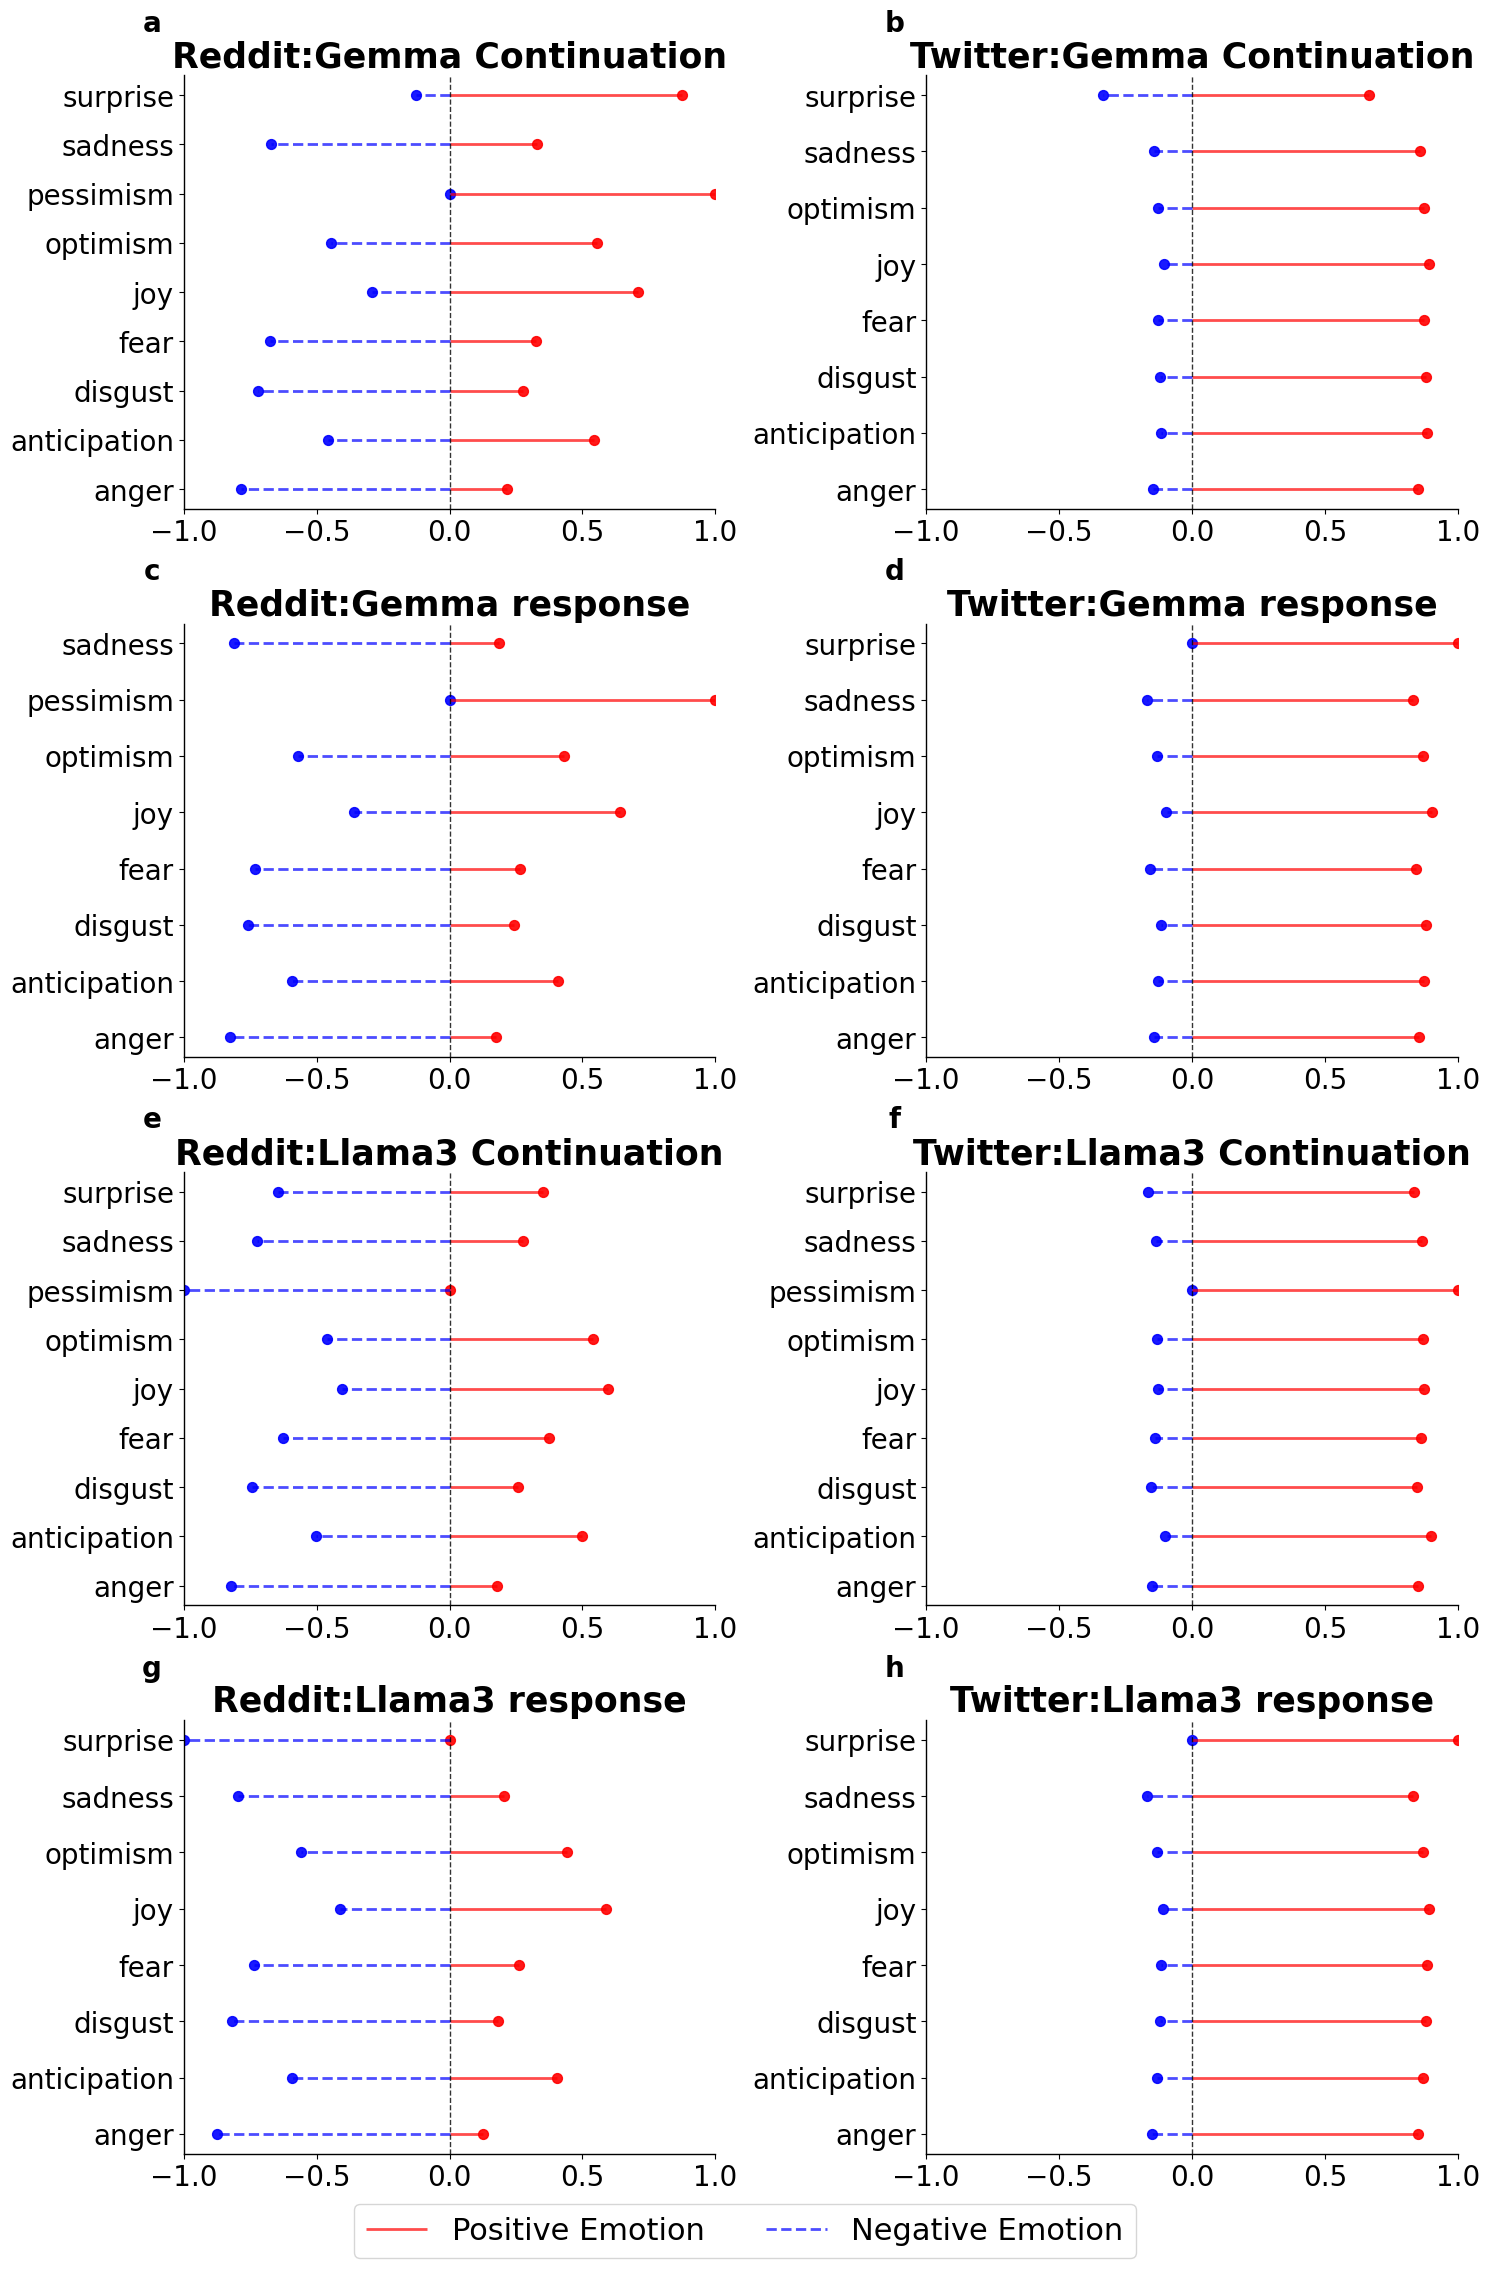

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
pos = ['anticipation', 'joy', 'love', 'optimism', 'surprise', 'trust']
neg = ['anger', 'disgust', 'fear', 'pessimism', 'sadness']

def process_and_plot(model_label, title, ax):
    treemap_data = Reddit.groupby([model_label, 'orginal_label']).size().reset_index(name='count')
    group_totals = treemap_data.groupby(model_label)['count'].transform('sum')
    treemap_data['percent'] = treemap_data['count'] / group_totals

    treemap_data['sentiment source'] = treemap_data['orginal_label'].apply(
        lambda x: 'negative' if x in neg else 'positive'
    )
    treemap_data['percent_adjusted'] = treemap_data.apply(
        lambda row: row['percent'] if row['sentiment source'] == 'positive' else -row['percent'], axis=1
    )

    summary = treemap_data.groupby([model_label, 'sentiment source'])['percent_adjusted'].sum().reset_index()
    plot_data = summary.pivot(index=model_label, columns='sentiment source', values='percent_adjusted').fillna(0)


    expand_labels = plot_data.index.tolist()
    #expand_labels = ['anger', 'disgust', 'fear', 'sadness','pessimism', 'anticipation', 'optimism', 'joy', 'surprise']  
    x_positive = plot_data['positive'].values if 'positive' in plot_data.columns else [0] * len(expand_labels)
    x_negative = plot_data['negative'].values if 'negative' in plot_data.columns else [0] * len(expand_labels)
    y = range(len(expand_labels)) 


    ax.hlines(y, 0, x_positive, colors='red', linestyles='-', linewidth=2, alpha=0.7, label='Positive Sentiment')
    ax.hlines(y, 0, x_negative, colors='blue', linestyles='--', linewidth=2, alpha=0.7, label='Negative Sentiment')

    ax.scatter(x_positive, y, color='red', s=50, alpha=0.9)
    ax.scatter(x_negative, y, color='blue', s=50, alpha=0.9)

    ax.set_yticks(y)
    ax.set_xlim(-1, 1)
    ax.set_yticklabels(expand_labels, fontsize=20)
    ax.tick_params(labelsize = 20)
    #ax.set_xlabel('Percent', fontsize=15)
    ax.set_title(title, fontsize=25, fontweight='bold')
    ax.axvline(0, color='black', linewidth=1, linestyle='--', alpha=0.8)
    ax.grid(False)

    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.set_facecolor('white')

    
fig, axs = plt.subplots(4, 2, figsize=(15, 24))
#fig.suptitle("Sentiment Distribution Across Models", fontsize=16)

# draw subplots
process_and_plot('[gemma]expand_label', 'Reddit:Gemma Continuation', axs[0, 0])
process_and_plot_Twitter('[gemma]expand_label', 'Twitter:Gemma Continuation', axs[0, 1])
process_and_plot('[gemma]response_label', 'Reddit:Gemma response', axs[1, 0])
process_and_plot_Twitter('[gemma]response_label', 'Twitter:Gemma response', axs[1, 1])
process_and_plot('[llama3]expand_label', 'Reddit:Llama3 Continuation', axs[2, 0])
process_and_plot_Twitter('[llama3]expand_label', 'Twitter:Llama3 Continuation', axs[2, 1])
process_and_plot('[llama3]response_label', 'Reddit:Llama3 response', axs[3, 0])
process_and_plot_Twitter('[llama3]response_label', 'Twitter:Llama3 response', axs[3, 1])

# set subplots annotation
sub_labels = ['a', 'b', 'c', 'd', 'e', 'f','g','h'] 
for ax, label in zip(axs.flat, sub_labels):
    ax.annotate(label, xy=(-0.06, 1.12), xycoords='axes fraction', fontsize=20, fontweight='bold', ha='center', va='center')

handles, labels = axs[0, 0].get_legend_handles_labels()
labels = ['Positive Emotion', 'Negative Emotion']
fig.legend(handles, labels, title='', loc='lower center', ncol=2, fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("new_pic/sentiment_sources[Reddit+Twitter][2models]_v3.png", dpi = 300)
plt.show()


## 2.Quantitative analysis

### ANOVA 检验

In [ ]:
sentiment_values = Reddit['orginal_label'].value_counts()
sentiment_values 

orginal_label
anger           4742
anticipation    1961
disgust         1624
optimism        1433
fear             472
sadness          352
joy              307
surprise           9
Name: count, dtype: int64

In [ ]:
results_list = [
    Reddit['orginal_label'], 
    Reddit['[llama3]response_label'], 
    Reddit['[llama3]expand_label'],
    Reddit['[gemma]response_label'],
    Reddit['[gemma]expand_label']
]
results_union = set().union(*results_list)
results_union

{'anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'optimism',
 'pessimism',
 'sadness',
 'surprise'}

In [16]:
import scipy.stats as stats

sentiment = ['anger','anticipation','disgust','optimism','fear','sadness','joy','surprise']
sentiment = results_union
for i in sentiment:
    orginal_senti = Reddit[Reddit['orginal_label'] == i]
    llama_response =  Reddit[Reddit['[llama3]response_label'] == i]
    llama_expand = Reddit[Reddit['[llama3]expand_label'] == i]
    gemma_expand = Reddit[Reddit['[gemma]expand_label'] == i]
    gemma_response = Reddit[Reddit['[gemma]response_label'] == i]

    a = orginal_senti['orginal_score'].to_list()
    b = llama_response['[llama3]response_score'].to_list()
    c = llama_expand['[llama3]expand_score'].to_list()
    d = gemma_response['[gemma]response_score'].to_list()
    e = gemma_expand['[gemma]expand_score'].to_list()
    
    anova_result = stats.f_oneway(a, b, c, d, e)
    
    print(f"ANOVA results for sentiment '{i}':")
    print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}")
    
    if anova_result.pvalue < 0.05:
        print(f"The differences between the groups for '{i}' are statistically significant.\n")
    else:
        print(f"No significant differences between the groups for '{i}'.\n")

ANOVA results for sentiment 'anticipation':
F-statistic: 80.8988, p-value: 1.1832e-67
The differences between the groups for 'anticipation' are statistically significant.

ANOVA results for sentiment 'sadness':
F-statistic: 18.7364, p-value: 3.5764e-15
The differences between the groups for 'sadness' are statistically significant.

ANOVA results for sentiment 'joy':
F-statistic: 5.1499, p-value: 4.0198e-04
The differences between the groups for 'joy' are statistically significant.

ANOVA results for sentiment 'anger':
F-statistic: 197.3160, p-value: 6.5500e-166
The differences between the groups for 'anger' are statistically significant.

ANOVA results for sentiment 'optimism':
F-statistic: 59.5260, p-value: 6.8306e-50
The differences between the groups for 'optimism' are statistically significant.

ANOVA results for sentiment 'surprise':
F-statistic: nan, p-value: nan
No significant differences between the groups for 'surprise'.

ANOVA results for sentiment 'pessimism':
F-statistic: n

/tmp/ipykernel_8571/4018623138.py:18: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  anova_result = stats.f_oneway(a, b, c, d, e)


F-test results: *surprise* is not significant


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd
sentiment = set(Reddit['orginal_label'])

for i in sentiment:
    orginal_senti = Reddit[Reddit['orginal_label'] == i]
    llama_response = Reddit[Reddit['[llama3]response_label'] == i]
    llama_expand = Reddit[Reddit['[llama3]expand_label'] == i]
    gemma_expand = Reddit[Reddit['[gemma]expand_label'] == i]
    gemma_response = Reddit[Reddit['[gemma]response_label'] == i]

    data = pd.DataFrame({
        'scores': pd.concat([
            orginal_senti['orginal_score'],
            llama_response['[llama3]response_score'],
            llama_expand['[llama3]expand_score'],
            gemma_response['[gemma]response_score'],
            gemma_expand['[gemma]expand_score']
        ]),
        'group': (
            ['Original'] * len(orginal_senti) +
            ['Llama Response'] * len(llama_response) +
            ['Llama Expand'] * len(llama_expand) +
            ['Gemma Response'] * len(gemma_response) +
            ['Gemma Expand'] * len(gemma_expand)
        )
    })

    # Tukey HSD test
    tukey = pairwise_tukeyhsd(endog=data['scores'], groups=data['group'], alpha=0.05)
    #tukey_summary = tukey.summary()
    #tukey_summary
    
    print(f"Tukey's HSD Test for sentiment '{i}':")
    print(tukey)
    print("\n")

Tukey's HSD Test for sentiment 'surprise':
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------
  Gemma Expand   Llama Expand   0.0568 0.2896 -0.0285 0.1421  False
  Gemma Expand Llama Response   0.1266 0.3781 -0.0844 0.3376  False
  Gemma Expand       Original   0.0218 0.9276 -0.0749 0.1184  False
  Llama Expand Llama Response   0.0698 0.7913 -0.1349 0.2745  False
  Llama Expand       Original   -0.035 0.6573  -0.117  0.047  False
Llama Response       Original  -0.1048 0.5352 -0.3145 0.1049  False
-------------------------------------------------------------------


Tukey's HSD Test for sentiment 'anticipation':
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
  Gemma Expand Gemma 

## 3.Embedding

In [3]:
df = pd.read_csv("data/Reddit_fulldata_forembedding[gemma expand].csv")

In [6]:
df2 = pd.read_csv("data/Reddit_fulldata_forembedding[gemma response].csv")
gemma_response = df2.set_index('author')['response gemma embed'].to_dict()

In [7]:
df3 = pd.read_csv("data/Reddit_fulldata_forembedding[llama response].csv")
llama_response = df3.set_index('author')['response llama embed'].to_dict()

In [8]:
df4 = pd.read_csv("data/Reddit_fulldata_forembedding[llama expand].csv")
llama_expand = df4.set_index('author')['expand llama embed'].to_dict()
df['response gemma embed'] = df['author'].map(gemma_response)
df['response llama embed'] = df['author'].map(llama_response)
df['expand llama embed'] = df['author'].map(llama_expand)

In [ ]:
df.to_csv("data/Reddit_fulldata_forembedding[gemma expand].csv", index = False)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_utc             10900 non-null  object 
 1   author                  10900 non-null  object 
 2   subreddit               10900 non-null  object 
 3   body                    10900 non-null  object 
 4   parent_id               10897 non-null  object 
 5   subreddit_id            10897 non-null  object 
 6   id                      10897 non-null  object 
 7   lang                    290 non-null    object 
 8   gemma2 expand           10900 non-null  object 
 9   label[orginal text]     10900 non-null  object 
 10  score[orginal text]     10900 non-null  float64
 11  label[gemma2 expand]    10900 non-null  object 
 12  score[gemma2 expand]    10900 non-null  float64
 13  orginal_label           10900 non-null  object 
 14  orginal_score           10900 non-null

### 3.1 Models difference

In [ ]:
df = pd.read_csv("data/fulldata_forembedding[Reddit][withorginal].csv") # [withorginal]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_utc             10900 non-null  object 
 1   author                  10900 non-null  object 
 2   subreddit               10900 non-null  object 
 3   body                    10900 non-null  object 
 4   parent_id               10897 non-null  object 
 5   subreddit_id            10897 non-null  object 
 6   id                      10897 non-null  object 
 7   lang                    290 non-null    object 
 8   gemma2 expand           10900 non-null  object 
 9   label[orginal text]     10900 non-null  object 
 10  score[orginal text]     10900 non-null  float64
 11  label[gemma2 expand]    10900 non-null  object 
 12  score[gemma2 expand]    10900 non-null  float64
 13  orginal_label           10900 non-null  object 
 14  orginal_score           10900 non-null

#### cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

body_gemma_embeddings = np.array(orginal['body_gemma_embed'].values.tolist())
expand_gemma_embeddings = np.array(orginal['expand_gemma_embed'].values.tolist())

cosine_similarities = [
    cosine_similarity(embed1.reshape(1, -1), embed2.reshape(1, -1))[0, 0]
    for embed1, embed2 in zip(body_gemma_embeddings, expand_gemma_embeddings)
]


print(cosine_similarities)
print(len(cosine_similarities))


[np.float64(0.5199281409651626), np.float64(0.5998113853045137), np.float64(0.518935263053155), np.float64(0.5086992355938054), np.float64(0.5094954164854143), np.float64(0.4389996742623805), np.float64(0.5314184144767031), np.float64(0.7700176224792579), np.float64(0.7439915318187137), np.float64(0.4821445810065421), np.float64(0.6976851723846167), np.float64(0.6811168393221054), np.float64(0.6858956299966037), np.float64(0.780958027387934), np.float64(0.42412176428090975), np.float64(0.5201912620326457), np.float64(0.85464377949514), np.float64(0.7358096726621791), np.float64(0.39334190859783635), np.float64(0.5682319437618852), np.float64(0.6726287317378533), np.float64(0.4403584828450498), np.float64(0.6236722444338794), np.float64(0.7939338201149775), np.float64(0.46145338951264714), np.float64(0.5859558198006536), np.float64(0.5250098842808668), np.float64(0.748503784965422), np.float64(0.44898035202976877), np.float64(0.4179250311435189), np.float64(0.5009714771791036), np.float

In [15]:
orginal['consine[gemma_expand]'] = cosine_similarities

/tmp/ipykernel_3834134/1141620841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orginal['consine[gemma_expand]'] = cosine_similarities


In [ ]:
label_similarity = (
    orginal.groupby('[gemma]expand_label')['consine[gemma_expand]']
    .mean()
    .reset_index()
    .sort_values('consine[gemma_expand]', ascending=False)
)


print(label_similarity)

  [gemma]expand_label  consine[gemma_expand]
6           pessimism               0.619625
5            optimism               0.618067
1        anticipation               0.606817
3                fear               0.604286
4                 joy               0.602613
2             disgust               0.596799
0               anger               0.595455
7             sadness               0.580541
8            surprise               0.555247


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_utc             10900 non-null  object 
 1   author                  10900 non-null  object 
 2   subreddit               10900 non-null  object 
 3   body                    10900 non-null  object 
 4   parent_id               10897 non-null  object 
 5   subreddit_id            10897 non-null  object 
 6   id                      10897 non-null  object 
 7   lang                    290 non-null    object 
 8   gemma2 expand           10900 non-null  object 
 9   label[orginal text]     10900 non-null  object 
 10  score[orginal text]     10900 non-null  float64
 11  label[gemma2 expand]    10900 non-null  object 
 12  score[gemma2 expand]    10900 non-null  float64
 13  orginal_label           10900 non-null  object 
 14  orginal_score           10900 non-null

In [15]:
empty = pd.read_csv("data/Reddit_empty_forembedding[llama response].csv")
empty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_utc             3230 non-null   object 
 1   author                  3230 non-null   object 
 2   subreddit               3230 non-null   object 
 3   body                    3230 non-null   object 
 4   parent_id               3230 non-null   object 
 5   subreddit_id            3230 non-null   object 
 6   id                      3230 non-null   object 
 7   lang                    6 non-null      object 
 8   gemma2 expand           3230 non-null   object 
 9   label[orginal text]     3230 non-null   object 
 10  score[orginal text]     3230 non-null   float64
 11  label[gemma2 expand]    3230 non-null   object 
 12  score[gemma2 expand]    3230 non-null   float64
 13  orginal_label           3230 non-null   object 
 14  orginal_score           3230 non-null   

In [16]:
empty_dict = empty.set_index('author')['response llama embed'].to_dict()
df.loc[df['response llama embed'].isna(), 'response llama embed'] = (
    df['author'].map(empty_dict)
) # update the null embed value

In [17]:
df.info()
df.to_csv("data/Reddit_empty_forembedding[llama response].csv", index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_utc             10900 non-null  object 
 1   author                  10900 non-null  object 
 2   subreddit               10900 non-null  object 
 3   body                    10900 non-null  object 
 4   parent_id               10897 non-null  object 
 5   subreddit_id            10897 non-null  object 
 6   id                      10897 non-null  object 
 7   lang                    290 non-null    object 
 8   gemma2 expand           10900 non-null  object 
 9   label[orginal text]     10900 non-null  object 
 10  score[orginal text]     10900 non-null  float64
 11  label[gemma2 expand]    10900 non-null  object 
 12  score[gemma2 expand]    10900 non-null  float64
 13  orginal_label           10900 non-null  object 
 14  orginal_score           10900 non-null

In [18]:
import json
df['expand_gemma_embed'] = df['expand gemma embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)
df['body_gemma_embed'] = df['body gemma embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)
df['response_gemma_embed'] = df['response gemma embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)
df['response_llama_embed'] = df['response llama embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)
df['expand_llama_embed'] = df['expand llama embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)
df['body_llama_embed'] = df['body llama embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)

In [19]:
df['expand_gemma_embed'] = df['expand_gemma_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
df['body_gemma_embed'] = df['body_gemma_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
df['response_gemma_embed'] = df['response_gemma_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
df['body_llama_embed'] = df['body_llama_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
df['expand_llama_embed'] = df['expand_llama_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
df['response_llama_embed'] = df['response_llama_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
print(df['expand_gemma_embed'].head())

0    [-1.4718751907348633, -1.053913950920105, 0.22...
1    [-1.8467713594436646, -0.3226895332336426, -0....
2    [-1.7816510200500488, -0.5935853719711304, -0....
3    [-2.549649238586426, 0.257380872964859, -1.229...
4    [-2.709265947341919, 0.3547946512699127, -2.45...
Name: expand_gemma_embed, dtype: object


In [20]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

body_gemma_embeddings = np.array(df['body_gemma_embed'].values.tolist())
expand_gemma_embeddings = np.array(df['expand_gemma_embed'].values.tolist())

cosine_similarities = [
    cosine_similarity(embed1.reshape(1, -1), embed2.reshape(1, -1))[0, 0]
    for embed1, embed2 in zip(body_gemma_embeddings, expand_gemma_embeddings)
]


print(cosine_similarities)
print(len(cosine_similarities))


[np.float64(0.5679596364294008), np.float64(0.39307106546961834), np.float64(0.7548342304164051), np.float64(0.6660311469896882), np.float64(0.5199281409651626), np.float64(0.5489510647113347), np.float64(0.8161646255074844), np.float64(0.5998113853045137), np.float64(0.5808794645744411), np.float64(0.442673430802521), np.float64(0.38032721853831597), np.float64(0.6333166732662144), np.float64(0.518935263053155), np.float64(0.773771269050432), np.float64(0.5086992355938054), np.float64(0.44208698364902543), np.float64(0.491832852172209), np.float64(0.4969541653336751), np.float64(0.5094954164854143), np.float64(0.4389996742623805), np.float64(0.7159301975257654), np.float64(0.5314184144767031), np.float64(0.7700176224792579), np.float64(0.7439915318187137), np.float64(0.4821445810065421), np.float64(0.6976851723846167), np.float64(0.5379987825853911), np.float64(0.6811168393221054), np.float64(0.5780840362083355), np.float64(0.696006165982283), np.float64(0.6943981952316927), np.float6

In [21]:
df['consine[gemma_expand]'] = cosine_similarities

In [22]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

response_gemma_embeddings = np.array(df['response_gemma_embed'].values.tolist())

cosine_similarities = [
    cosine_similarity(embed1.reshape(1, -1), embed2.reshape(1, -1))[0, 0]
    for embed1, embed2 in zip(body_gemma_embeddings, response_gemma_embeddings)
]
df['consine[gemma_response]'] = cosine_similarities

print(cosine_similarities)
print(len(cosine_similarities))


[np.float64(0.6401988432545931), np.float64(0.4369461590441023), np.float64(0.6707871053844414), np.float64(0.7227311955326353), np.float64(0.4958693799739895), np.float64(0.5266943023257353), np.float64(0.8112241295562255), np.float64(0.5873943823374057), np.float64(0.7049762446996798), np.float64(0.32844668130610494), np.float64(0.5960494037903761), np.float64(0.7697131434390955), np.float64(0.4686736998760949), np.float64(0.7119592786202218), np.float64(0.6220045365920344), np.float64(0.5298174649771908), np.float64(0.5059038874976034), np.float64(0.7460346951636057), np.float64(0.3422372330309169), np.float64(0.6686285291272684), np.float64(0.6867134396523643), np.float64(0.6576023437272209), np.float64(0.8042643640372135), np.float64(0.7653241922058716), np.float64(0.23936665644442218), np.float64(0.8100061511583705), np.float64(0.6741538046542402), np.float64(0.6168238112940917), np.float64(0.659551071723044), np.float64(0.7070389184601924), np.float64(0.6477416109251207), np.flo

In [23]:
# cosine similarity
text_llama_embeddings = np.array(df['body_llama_embed'].values.tolist())
expand_llama_embeddings = np.array(df['expand_llama_embed'].values.tolist())

cosine_similarities = [
    cosine_similarity(embed1.reshape(1, -1), embed2.reshape(1, -1))[0, 0]
    for embed1, embed2 in zip(text_llama_embeddings, expand_llama_embeddings)
]
df['consine[llama_expand]'] = cosine_similarities

print(cosine_similarities)
print(len(cosine_similarities))


[np.float64(0.8036591096131191), np.float64(0.3773235294243668), np.float64(0.75000757602052), np.float64(0.7311850106888587), np.float64(0.5313603381794274), np.float64(0.40396570669439447), np.float64(0.7308035938738324), np.float64(0.36196465519131826), np.float64(0.7725421872145759), np.float64(0.38616212779564296), np.float64(0.5392990601928119), np.float64(0.6995663146736755), np.float64(0.562922903532644), np.float64(0.43548989574245034), np.float64(0.6295030706941154), np.float64(0.49869442889266324), np.float64(0.6159703681373416), np.float64(0.6210692537037567), np.float64(0.5116858073797192), np.float64(0.527174630603707), np.float64(0.6296942969139645), np.float64(0.5487716317835698), np.float64(0.6696801692641448), np.float64(0.6673700672320899), np.float64(0.52301516446231), np.float64(0.65317874018082), np.float64(0.5918772854564018), np.float64(0.5732576020040301), np.float64(0.5657032741517831), np.float64(0.4977212621991676), np.float64(0.6901269277425384), np.float64

In [24]:
expand_llama_embeddings = np.array(df['response_llama_embed'].values.tolist())

cosine_similarities = [
    cosine_similarity(embed1.reshape(1, -1), embed2.reshape(1, -1))[0, 0]
    for embed1, embed2 in zip(text_llama_embeddings, expand_llama_embeddings)
]
df['consine[llama_response]'] = cosine_similarities

print(cosine_similarities)
print(len(cosine_similarities))

[np.float64(0.7137014187171696), np.float64(0.4552623264909476), np.float64(0.637241173497057), np.float64(0.7261738368613841), np.float64(0.40424864749572054), np.float64(0.3977978704808762), np.float64(0.6784466332209705), np.float64(0.21331488520284658), np.float64(0.5799457240807016), np.float64(0.35499687860639056), np.float64(0.525883601272576), np.float64(0.6470371986021832), np.float64(0.5556121784687147), np.float64(0.3522205135024669), np.float64(0.6049372725496365), np.float64(0.5021568895641854), np.float64(0.6605449015258463), np.float64(0.6596911359060253), np.float64(0.4446760243207226), np.float64(0.4947445198033274), np.float64(0.4496450478525008), np.float64(0.4551288851466131), np.float64(0.6742288223813726), np.float64(0.5867986233664755), np.float64(0.5628031714780518), np.float64(0.6036511768215782), np.float64(0.43743006318806427), np.float64(0.5554535070888901), np.float64(0.5229764184413509), np.float64(0.45825831197232025), np.float64(0.6657989683622205), np.f

/tmp/ipykernel_975774/2521942921.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Type', y='Value', data=df_melted, palette="muted", cut=0)


<Figure size 1200x800 with 0 Axes>

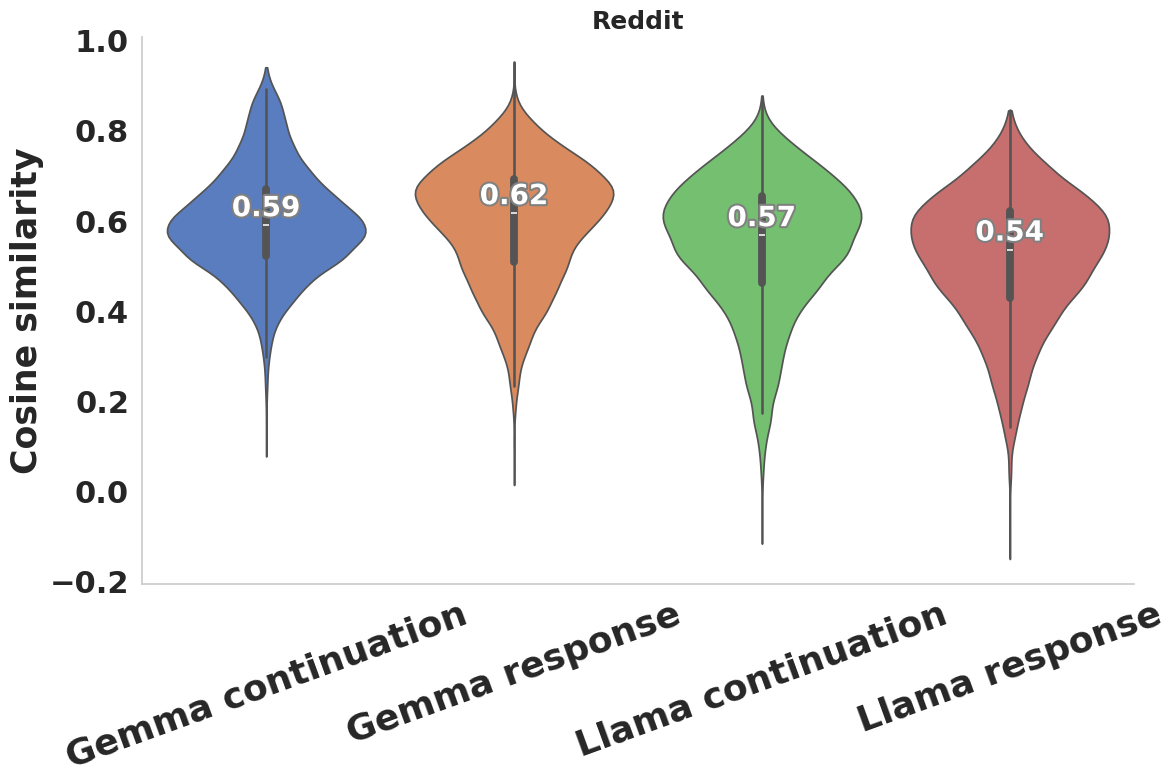

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
plt.figure(figsize=(12, 8))

df_melted = df.melt(
    value_vars=['consine[gemma_expand]', 'consine[gemma_response]', 
                'consine[llama_expand]', 'consine[llama_response]'], 
    var_name='Type', 
    value_name='Value'
)
df_melted['Type'] = df_melted['Type'].replace({
    'consine[gemma_expand]': 'Gemma continuation',
    'consine[gemma_response]': 'Gemma response',
    'consine[llama_expand]': 'Llama continuation',
    'consine[llama_response]': 'Llama response'
})

sns.set(style="whitegrid")
medians = df_melted.groupby('Type')['Value'].median()


plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='Type', y='Value', data=df_melted, palette="muted", cut=0)

offset = 0.02  
for i, type_group in enumerate(medians.index):
    median_value = medians[type_group]
    text = ax.text(
        i, median_value + offset, f'{median_value:.2f}',  # position adjust
        horizontalalignment='center', color='white', fontsize=20, 
        fontweight='bold'
    )
    text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='gray'),  
        path_effects.Normal()  
    ])

plt.title('Reddit', fontsize=18, fontweight = 'bold')
plt.xlabel('', fontsize=12)
plt.ylabel('Cosine similarity', fontsize=25, fontweight = 'bold')
plt.grid(False)

ax = plt.gca()  # get axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# show
plt.xticks(fontsize = 26,rotation=20, fontweight = 'bold')
plt.yticks(fontsize = 22,fontweight = 'bold')
plt.tight_layout()
plt.savefig('new_pic/[Reddit][4task_embedding_cosine_violine]2.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# M-W U test
# within groups
print(f"Gemma的续写与回复的cosine similarity:") ##Cosine similarity of Gemma's continuation and replies
Mann_Whitney_U_test(df['consine[gemma_expand]'].to_list(), df['consine[gemma_response]'].to_list())
print(f"Llama的续写与回复的cosine similarity:") ##Cosine similarity of Llama's continuation and replies
Mann_Whitney_U_test(df['consine[llama_expand]'].to_list(), df['consine[llama_response]'].to_list())

Gemma的续写与回复的cosine similarity:
U统计量: 56740052.0, P值: 4.8448811592477244e-09, 前者整体显著比后者小。
Llama的续写与回复的cosine similarity:
U统计量: 66851679.0, P值: 4.0509691063158256e-58, 前者整体显著比后者大。


In [ ]:
u_statistic, p_value = mannwhitneyu(df['consine[gemma_expand]'].to_list(), df['consine[gemma_response]'].to_list(), alternative='greater')
print(f"U statistics: {u_statistic}, P-value: {p_value}", end=', ')

U统计量: 56740052.0, P值: 0.9999999951551803, 

In [ ]:
# inter groups
print(f"Gemma的续写与Llama的续写cosine similarity:") # Cosine similarity of Gemma's Continuation and Llama's Continuation
Mann_Whitney_U_test(df['consine[gemma_expand]'].to_list(), df['consine[llama_expand]'].to_list())
print(f"Gemma的回复与Llama的回复的cosine similarity:")# Cosine similarity of Gemma's response and Llama's response
Mann_Whitney_U_test(df['consine[gemma_response]'].to_list(), df['consine[llama_response]'].to_list())

Gemma的续写与Llama的续写cosine similarity:
U统计量: 68723025.0, P值: 8.90040943618698e-90, 前者整体显著比后者大。
Gemma的回复与Llama的回复的cosine similarity:
U统计量: 78292192.0, P值: 0.0, 前者整体显著比后者大。


In [75]:
statistics = df[['consine[gemma_expand]', 'consine[gemma_response]', 
                'consine[llama_expand]', 'consine[llama_response]']].describe()
statistics

consine[gemma_expand]  consine[gemma_response]  consine[llama_expand]  \
count           10900.000000             10900.000000           10900.000000   
mean                0.598579                 0.597441               0.546697   
std                 0.118211                 0.130935               0.148718   
min                 0.078279                 0.014985              -0.115016   
25%                 0.521643                 0.509663               0.462379   
50%                 0.590903                 0.617610               0.568902   
75%                 0.670105                 0.693887               0.655079   
max                 0.941103                 0.952371               0.877805   

       consine[llama_response]  
count             10900.000000  
mean                  0.518666  
std                   0.143089  
min                  -0.149023  
25%                   0.430553  
50%                   0.536822  
75%                   0.622525  
max                   0.845351

# Twitter Platform

In [11]:
Twitter = pd.read_csv("data_Twitter/Twitter[topic=climatechange][model:llama+gemma]_[task:response+expand].csv")
Twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               12200 non-null  int64  
 1   conversation_id                  12200 non-null  float64
 2   referenced_tweets.replied_to.id  9831 non-null   float64
 3   author_id                        12200 non-null  int64  
 4   in_reply_to_user_id              9831 non-null   float64
 5   in_reply_to_username             3473 non-null   object 
 6   text                             12200 non-null  object 
 7   author.username                  12200 non-null  object 
 8   text length                      12200 non-null  int64  
 9   date                             12200 non-null  object 
 10  llama3 response                  12200 non-null  object 
 11  [llama3]response_label           12200 non-null  object 
 12  [llama3]response_s

### 1.Senti analysis

#### *Heatmap*

In [26]:
orginal_emotions = df['orginal_label'].value_counts()
orginal_emotions

orginal_label
anticipation    6849
joy             3694
disgust         1130
anger            432
sadness           64
fear              28
optimism           3
Name: count, dtype: int64

/tmp/ipykernel_975774/3296276612.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


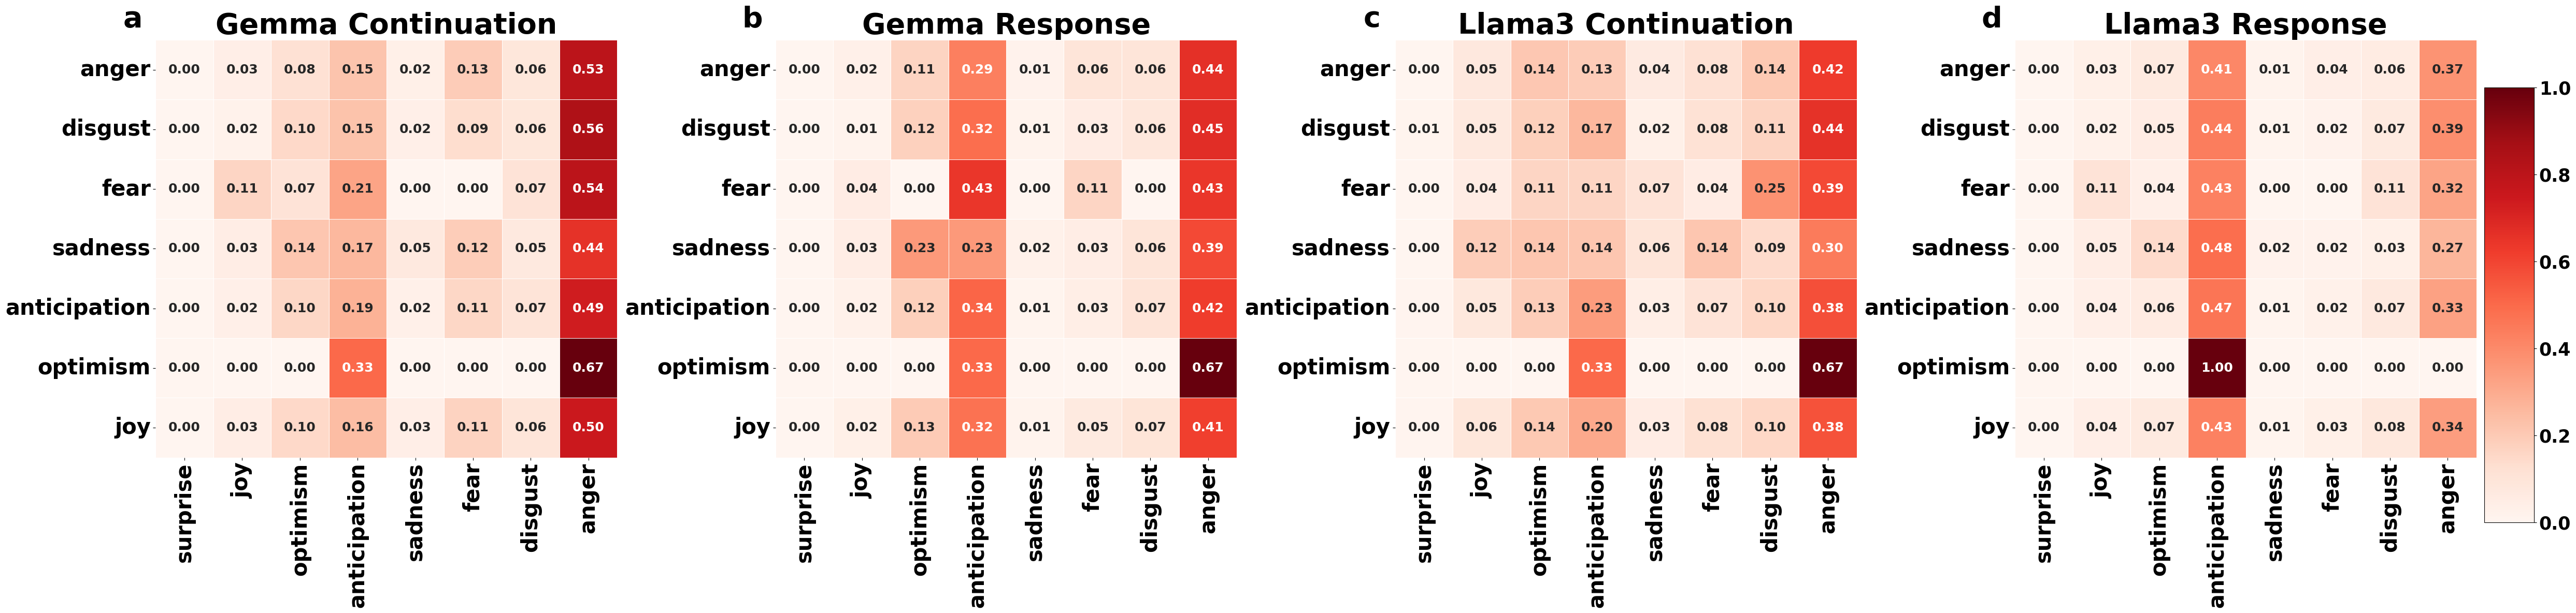

In [12]:
import numpy as np
df = Twitter # adjust the variant
# subplot
columns = ["[gemma]expand_label", "[gemma]response_label", "[llama3]expand_label", "[llama3]response_label"]
titles = ["Gemma Continuation", "Gemma Response", "Llama3 Continuation", "Llama3 Response"]
vmin, vmax = 0, 1
sub_labels = ['a', 'b', 'c', 'd'] 
fig, axes = plt.subplots(1, 4, figsize=(48, 12))
axes = axes.flatten()

for i, col in enumerate(columns):
    transition_matrix = pd.crosstab(
        df["orginal_label"], 
        df[col],
        rownames=["Original"],
        colnames=[col]
    )
    transition_matrix_normalized = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    emotions_order = ['anger', 'disgust', 'fear', 'sadness', 'anticipation', 'optimism', 'joy']
    transition_matrix_normalized_2 = transition_matrix_normalized.reindex(index=emotions_order)
    change_column = ['surprise', 'joy','optimism','anticipation','sadness','fear','disgust','anger']
    transition_matrix_normalized_2 = transition_matrix_normalized_2.reindex(columns = change_column)
    
    sns.heatmap(
        transition_matrix_normalized_2, 
        annot=True, 
        fmt=".2f", 
        cmap="Reds", 
        cbar=False,
        ax=axes[i], 
        linewidths=0.5,
        annot_kws={"size": 18, "weight": "bold"}
    )

    #axes[i].set_title(f"{titles[i]} Transition")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=30, fontweight="bold", rotation = 90) 
    axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=30, fontweight="bold", rotation = 0)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(f"{titles[i]}", fontsize=40,fontweight='bold')
    
    axes[i].annotate(
        sub_labels[i], 
        xy=(-0.05, 1.05), 
        xycoords='axes fraction', 
        fontsize=40, 
        fontweight='bold', 
        ha='center', 
        va='center'
    )
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7]) 
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=25)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')


plt.tight_layout()
plt.savefig("new_pic/heatmap[Twitter][2models]_normalized_v4.png", dpi = 300, bbox_inches='tight')
plt.savefig("new_pic/heatmap[Twitter][2models]_normalized.pdf", dpi = 300, bbox_inches='tight')
plt.show()


#### *Horizontal lines*

In [41]:
value = df['orginal_label'].value_counts()
value

orginal_label
anticipation    6849
joy             3694
disgust         1130
anger            432
sadness           64
fear              28
optimism           3
Name: count, dtype: int64

In [39]:
treemap_data = df.groupby(['[llama3]expand_label', 'orginal_label']).size().reset_index(name='count')
group_totals = treemap_data.groupby('[llama3]expand_label')['count'].transform('sum')
treemap_data['percent'] = treemap_data['count'] / group_totals

pos = ['anticipation ','joy', 'love', 'optimism','surprise', 'trust']
neg = ['anger', 'disgust', 'fear', 'pessimism', 'sadness']
treemap_data['sentiment source'] = treemap_data['orginal_label'].apply(lambda x: 'negative' if x in neg else 'positive')  

In [40]:
treemap_data   

[llama3]expand_label orginal_label  count   percent sentiment source
0                 anger         anger    181  0.038453         negative
1                 anger  anticipation   2607  0.553856         positive
2                 anger       disgust    497  0.105587         negative
3                 anger          fear     11  0.002337         negative
4                 anger           joy   1390  0.295305         positive
5                 anger      optimism      2  0.000425         positive
6                 anger       sadness     19  0.004037         negative
7          anticipation         anger     56  0.021613         negative
8          anticipation  anticipation   1574  0.607487         positive
9          anticipation       disgust    197  0.076032         negative
10         anticipation          fear      3  0.001158         negative
11         anticipation           joy    751  0.289849         positive
12         anticipation      optimism      1  0.000386         positive
13         anticipation       sadness      9  0.003474         negative
14              disgust         anger     59  0.045986         negative
15              disgust  anticipation    703  0.547935         positive
16              disgust       disgust    125  0.097428         negative
17              disgust          fear      7  0.005456         negative
18              disgust           joy    383  0.298519         positive
19              disgust       sadness      6  0.004677         negative
20                 fear         anger     34  0.036442         negative
21                 fear  anticipation    496  0.531618         positive
22                 fear       disgust     86  0.092176         negative
23                 fear          fear      1  0.001072         negative
24                 fear           joy    307  0.329046         positive
25                 fear       sadness      9  0.009646         negative
26                  joy         anger     22  0.032544         negative
27                  joy  anticipation    370  0.547337         positive
28                  joy       disgust     55  0.081361         negative
29                  joy          fear      1  0.001479         negative
30                  joy           joy    220  0.325444         positive
31                  joy       sadness      8  0.011834         negative
32             optimism         anger     60  0.037951         negative
33             optimism  anticipation    866  0.547755         positive
34             optimism       disgust    137  0.086654         negative
35             optimism          fear      3  0.001898         negative
36             optimism           joy    506  0.320051         positive
37             optimism       sadness      9  0.005693         negative
38            pessimism  anticipation      1  1.000000         positive
39              sadness         anger     19  0.050000         negative
40              sadness  anticipation    203  0.534211         positive
41              sadness       disgust     26  0.068421         negative
42              sadness          fear      2  0.005263         negative
43              sadness           joy    126  0.331579         positive
44              sadness       sadness      4  0.010526         negative
45             surprise         anger      1  0.020833         negative
46             surprise  anticipation     29  0.604167         positive
47             surprise       disgust      7  0.145833         negative
48             surprise           joy     11  0.229167         positive

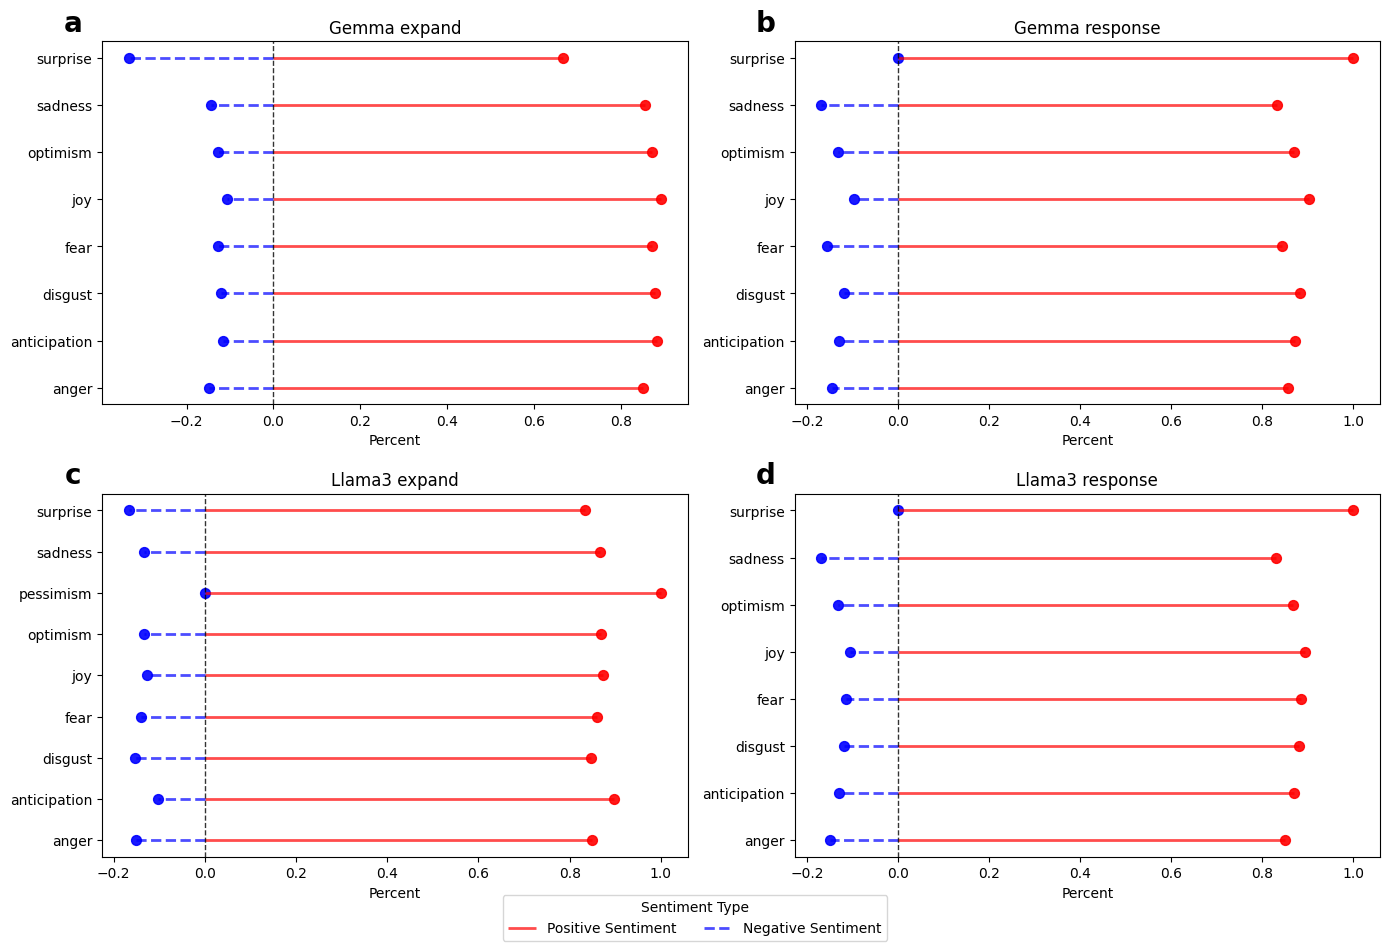

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
pos = ['anticipation', 'joy', 'love', 'optimism', 'surprise', 'trust']
neg = ['anger', 'disgust', 'fear', 'pessimism', 'sadness']

def process_and_plot(model_label, title, ax):
   
    treemap_data = df.groupby([model_label, 'orginal_label']).size().reset_index(name='count')
    group_totals = treemap_data.groupby(model_label)['count'].transform('sum')
    treemap_data['percent'] = treemap_data['count'] / group_totals
    treemap_data['sentiment source'] = treemap_data['orginal_label'].apply(
        lambda x: 'negative' if x in neg else 'positive'
    )
    treemap_data['percent_adjusted'] = treemap_data.apply(
        lambda row: row['percent'] if row['sentiment source'] == 'positive' else -row['percent'], axis=1
    )

    summary = treemap_data.groupby([model_label, 'sentiment source'])['percent_adjusted'].sum().reset_index()
    plot_data = summary.pivot(index=model_label, columns='sentiment source', values='percent_adjusted').fillna(0)

    expand_labels = plot_data.index.tolist()  # lable
    x_positive = plot_data['positive'].values if 'positive' in plot_data.columns else [0] * len(expand_labels)
    x_negative = plot_data['negative'].values if 'negative' in plot_data.columns else [0] * len(expand_labels)
    y = range(len(expand_labels))  # y axis position

    ax.hlines(y, 0, x_positive, colors='red', linestyles='-', linewidth=2, alpha=0.7, label='Positive Sentiment')
    ax.hlines(y, 0, x_negative, colors='blue', linestyles='--', linewidth=2, alpha=0.7, label='Negative Sentiment')
    ax.scatter(x_positive, y, color='red', s=50, alpha=0.9)
    ax.scatter(x_negative, y, color='blue', s=50, alpha=0.9)


    ax.set_yticks(y)
    ax.set_yticklabels(expand_labels, fontsize=10)
    ax.set_xlabel('Percent', fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.axvline(0, color='black', linewidth=1, linestyle='--', alpha=0.8)
    ax.grid(False)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
#fig.suptitle("Sentiment Distribution Across Models", fontsize=16)

# 绘制每个子图
process_and_plot('[gemma]expand_label', 'Gemma expand', axs[0, 0])
process_and_plot('[gemma]response_label', 'Gemma response', axs[0, 1])
process_and_plot('[llama3]expand_label', 'Llama3 expand', axs[1, 0])
process_and_plot('[llama3]response_label', 'Llama3 response', axs[1, 1])


sub_labels = ['a', 'b', 'c', 'd']  
for ax, label in zip(axs.flat, sub_labels):
    ax.annotate(label, xy=(-0.05, 1.05), xycoords='axes fraction', fontsize=20, fontweight='bold', ha='center', va='center')


handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title='Sentiment Type', loc='lower center', ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("new_pic/sentiment_sources[Twitter][2models]_normalized.png", dpi = 300)
plt.show()


## 2.Quantititatives Analysisa

### ANOVA Test

In [3]:
Twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               12200 non-null  int64  
 1   conversation_id                  12200 non-null  float64
 2   referenced_tweets.replied_to.id  9831 non-null   float64
 3   author_id                        12200 non-null  int64  
 4   in_reply_to_user_id              9831 non-null   float64
 5   in_reply_to_username             3473 non-null   object 
 6   text                             12200 non-null  object 
 7   author.username                  12200 non-null  object 
 8   text length                      12200 non-null  int64  
 9   date                             12200 non-null  object 
 10  llama3 response                  12200 non-null  object 
 11  [llama3]response_label           12200 non-null  object 
 12  [llama3]response_s

In [11]:
values = Twitter['orginal_label'].value_counts()
values

orginal_label
anticipation    6849
joy             3694
disgust         1130
anger            432
sadness           64
fear              28
optimism           3
Name: count, dtype: int64

In [8]:
sentiment = set(Twitter['orginal_label'].values)
sentiment

{'anger', 'anticipation', 'disgust', 'fear', 'joy', 'optimism', 'sadness'}

In [9]:
import scipy.stats as stats

sentiment = ['anticipation', 'anger', 'optimism', 'joy','disgust', 'sadness', 'fear','optimism']
sentiment = set(Twitter['orginal_label'].values)

for i in sentiment:
    orginal_senti = Twitter[Twitter['orginal_label'] == i]
    llama_response =  Twitter[Twitter['[llama3]response_label'] == i]
    llama_expand = Twitter[Twitter['[llama3]expand_label'] == i]
    gemma_expand = Twitter[Twitter['[gemma]expand_label'] == i]
    gemma_response = Twitter[Twitter['[gemma]response_label'] == i]

    a = orginal_senti['orginal_score'].to_list()
    b = llama_response['[llama3]response_score'].to_list()
    c = llama_expand['[llama3]expand_score'].to_list()
    d = gemma_response['[gemma]response_score'].to_list()
    e = gemma_expand['[gemma]expand_score'].to_list()
    
    anova_result = stats.f_oneway(a, b, c, d, e)
    
    print(f"ANOVA results for sentiment '{i}':")
    print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}")
    
    if anova_result.pvalue < 0.05:
        print(f"The differences between the groups for '{i}' are statistically significant.\n")
    else:
        print(f"No significant differences between the groups for '{i}'.\n")

ANOVA results for sentiment 'anticipation':
F-statistic: 16092.4791, p-value: 0.0000e+00
The differences between the groups for 'anticipation' are statistically significant.

ANOVA results for sentiment 'joy':
F-statistic: 1742.1628, p-value: 0.0000e+00
The differences between the groups for 'joy' are statistically significant.

ANOVA results for sentiment 'sadness':
F-statistic: 148.4112, p-value: 6.8491e-98
The differences between the groups for 'sadness' are statistically significant.

ANOVA results for sentiment 'anger':
F-statistic: 384.2851, p-value: 9.5078e-320
The differences between the groups for 'anger' are statistically significant.

ANOVA results for sentiment 'optimism':
F-statistic: 6.0884, p-value: 6.9529e-05
The differences between the groups for 'optimism' are statistically significant.

ANOVA results for sentiment 'disgust':
F-statistic: 179.1806, p-value: 1.7993e-143
The differences between the groups for 'disgust' are statistically significant.

ANOVA results for s

In [19]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd
sentiment = set(Twitter['orginal_label'])

for i in sentiment:
    orginal_senti = Twitter[Twitter['orginal_label'] == i]
    llama_response = Twitter[Twitter['[llama3]response_label'] == i]
    llama_expand = Twitter[Twitter['[llama3]expand_label'] == i]
    gemma_expand = Twitter[Twitter['[gemma]expand_label'] == i]
    gemma_response = Twitter[Twitter['[gemma]response_label'] == i]

    data = pd.DataFrame({
        'scores': pd.concat([
            orginal_senti['orginal_score'],
            llama_response['[llama3]response_score'],
            llama_expand['[llama3]expand_score'],
            gemma_response['[gemma]response_score'],
            gemma_expand['[gemma]expand_score']
        ]),
        'group': (
            ['Original'] * len(orginal_senti) +
            ['Llama Response'] * len(llama_response) +
            ['Llama Expand'] * len(llama_expand) +
            ['Gemma Response'] * len(gemma_response) +
            ['Gemma Expand'] * len(gemma_expand)
        )
    })

    tukey = pairwise_tukeyhsd(endog=data['scores'], groups=data['group'], alpha=0.05)
    #tukey_summary = tukey.summary()
    #tukey_summary
    print(f"Tukey's HSD Test for sentiment '{i}':")
    print(tukey)
    print("\n")

Tukey's HSD Test for sentiment 'anticipation':
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj  lower   upper  reject
-------------------------------------------------------------------
  Gemma Expand Gemma Response  -0.0192   0.0 -0.0256 -0.0128   True
  Gemma Expand   Llama Expand   0.0182   0.0  0.0113  0.0252   True
  Gemma Expand Llama Response  -0.0291   0.0 -0.0351  -0.023   True
  Gemma Expand       Original  -0.3365   0.0 -0.3424 -0.3306   True
Gemma Response   Llama Expand   0.0374   0.0  0.0314  0.0434   True
Gemma Response Llama Response  -0.0099   0.0 -0.0148 -0.0049   True
Gemma Response       Original  -0.3173   0.0  -0.322 -0.3126   True
  Llama Expand Llama Response  -0.0473   0.0 -0.0529 -0.0416   True
  Llama Expand       Original  -0.3547   0.0 -0.3602 -0.3492   True
Llama Response       Original  -0.3074   0.0 -0.3117 -0.3031   True
-------------------------------------------------------------------



## 3.Embedding

In [6]:
# 
df2 = pd.read_csv("data_Twitter/Twitter_fulldata_forembedding[text_2models].csv")
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               12200 non-null  int64  
 1   conversation_id                  12200 non-null  float64
 2   referenced_tweets.replied_to.id  9831 non-null   float64
 3   author_id                        12200 non-null  int64  
 4   in_reply_to_user_id              9831 non-null   float64
 5   in_reply_to_username             3473 non-null   object 
 6   text                             12200 non-null  object 
 7   author.username                  12200 non-null  object 
 8   text length                      12200 non-null  int64  
 9   date                             12200 non-null  object 
 10  llama3 response                  12200 non-null  object 
 11  [llama3]response_label           12200 non-null  object 
 12  [llama3]response_s

In [7]:
Twitter_embedding = pd.read_csv("data_Twitter/Twitter_fulldata_forembedding[gemma response].csv")
Twitter_embedding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               12200 non-null  int64  
 1   conversation_id                  12200 non-null  float64
 2   referenced_tweets.replied_to.id  9831 non-null   float64
 3   author_id                        12200 non-null  int64  
 4   in_reply_to_user_id              9831 non-null   float64
 5   in_reply_to_username             3473 non-null   object 
 6   text                             12200 non-null  object 
 7   author.username                  12200 non-null  object 
 8   text length                      12200 non-null  int64  
 9   date                             12200 non-null  object 
 10  llama3 response                  12200 non-null  object 
 11  [llama3]response_label           12200 non-null  object 
 12  [llama3]response_s

In [8]:
gemma_embed_dict = Twitter_embedding.set_index('author.username')['response gemma embed'].to_dict()
df2['response gemma embed'] = df2['author.username'].map(gemma_embed_dict)

In [9]:
df3 = pd.read_csv("data_Twitter/Twitter_fulldata_forembedding[llama expand].csv")
df3.info()
llama_expand_embed_dict = df3.set_index('author.username')['expand llama embed'].to_dict()
df2['expand llama embed'] = df2['author.username'].map(llama_expand_embed_dict)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               12200 non-null  int64  
 1   conversation_id                  12200 non-null  float64
 2   referenced_tweets.replied_to.id  9831 non-null   float64
 3   author_id                        12200 non-null  int64  
 4   in_reply_to_user_id              9831 non-null   float64
 5   in_reply_to_username             3473 non-null   object 
 6   text                             12200 non-null  object 
 7   author.username                  12200 non-null  object 
 8   text length                      12200 non-null  int64  
 9   date                             12200 non-null  object 
 10  llama3 response                  12200 non-null  object 
 11  [llama3]response_label           12200 non-null  object 
 12  [llama3]response_s

In [ ]:
df4 = pd.read_csv("data_Twitter/Twitter_fulldata_forembedding[llama response].csv")
df4.info()
llama_response_embed_dict = df4.set_index('author.username')['response llama embed'].to_dict()
df2['response llama embed'] = df2['author.username'].map(llama_response_embed_dict)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               12200 non-null  int64  
 1   conversation_id                  12200 non-null  float64
 2   referenced_tweets.replied_to.id  9831 non-null   float64
 3   author_id                        12200 non-null  int64  
 4   in_reply_to_user_id              9831 non-null   float64
 5   in_reply_to_username             3473 non-null   object 
 6   text                             12200 non-null  object 
 7   author.username                  12200 non-null  object 
 8   text length                      12200 non-null  int64  
 9   date                             12200 non-null  object 
 10  llama3 response                  12200 non-null  object 
 11  [llama3]response_label           12200 non-null  object 
 12  [llama3]response_s

In [11]:
df2.to_csv("data_Twitter/Twitter_fulldata_forembedding[fulldata].csv", index=False)

### Cosine Similarity

In [28]:
df2 = pd.read_csv("data_Twitter/Twitter_fulldata_forembedding[fulldata].csv")

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12200 entries, 0 to 12199
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               12200 non-null  int64  
 1   conversation_id                  12200 non-null  float64
 2   referenced_tweets.replied_to.id  9831 non-null   float64
 3   author_id                        12200 non-null  int64  
 4   in_reply_to_user_id              9831 non-null   float64
 5   in_reply_to_username             3473 non-null   object 
 6   text                             12200 non-null  object 
 7   author.username                  12200 non-null  object 
 8   text length                      12200 non-null  int64  
 9   date                             12200 non-null  object 
 10  llama3 response                  12200 non-null  object 
 11  [llama3]response_label           12200 non-null  object 
 12  [llama3]response_s

In [29]:
import json
df2['expand_gemma_embed'] = df2['expand gemma embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)
df2['text_gemma_embed'] = df2['text gemma embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)

print(df2['expand_gemma_embed'].head())

0    {'embedding': [-2.8706412315368652, -0.9834631...
1    {'embedding': [-2.4321751594543457, 0.14355489...
2    {'embedding': [-1.8857495784759521, 0.44799363...
3    {'embedding': [-2.611380100250244, -0.06957590...
4    {'embedding': [-1.8975673913955688, -1.0807497...
Name: expand_gemma_embed, dtype: object


In [30]:
df2['response_gemma_embed'] = df2['response gemma embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)
df2['response_llama_embed'] = df2['response llama embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)
df2['expand_llama_embed'] = df2['expand llama embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)
df2['text_llama_embed'] = df2['text llama embed'].apply(
    lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x
)

In [31]:
df2['expand_gemma_embed'] = df2['expand_gemma_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
df2['text_gemma_embed'] = df2['text_gemma_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
df2['response_gemma_embed'] = df2['response_gemma_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
df2['text_llama_embed'] = df2['text_llama_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
df2['expand_llama_embed'] = df2['expand_llama_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
df2['response_llama_embed'] = df2['response_llama_embed'].apply(lambda x: x['embedding'] if isinstance(x, dict) and 'embedding' in x else [])
print(df2['expand_gemma_embed'].head())

0    [-2.8706412315368652, -0.9834631085395813, -0....
1    [-2.4321751594543457, 0.1435548961162567, -0.9...
2    [-1.8857495784759521, 0.4479936361312866, -0.1...
3    [-2.611380100250244, -0.06957590579986572, -1....
4    [-1.8975673913955688, -1.080749750137329, -0.4...
Name: expand_gemma_embed, dtype: object


In [32]:
# cosine similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

body_gemma_embeddings = np.array(df2['text_gemma_embed'].values.tolist())
expand_gemma_embeddings = np.array(df2['expand_gemma_embed'].values.tolist())

cosine_similarities = [
    cosine_similarity(embed1.reshape(1, -1), embed2.reshape(1, -1))[0, 0]
    for embed1, embed2 in zip(body_gemma_embeddings, expand_gemma_embeddings)
]


print(cosine_similarities)
print(len(cosine_similarities))


[np.float64(0.7349160075217547), np.float64(0.5186001371752937), np.float64(0.4304308191934917), np.float64(0.736096772877811), np.float64(0.6762225492111171), np.float64(0.662080922776047), np.float64(0.3637137187131318), np.float64(0.5776344829871471), np.float64(0.632884986838517), np.float64(0.7246080749443529), np.float64(0.6375215348450699), np.float64(0.38159199076263683), np.float64(0.6544210247076027), np.float64(0.6521174300515085), np.float64(0.654032512364463), np.float64(0.7162824897126161), np.float64(0.5026787669401731), np.float64(0.6094174710869033), np.float64(0.6588417386163163), np.float64(0.6202515337436276), np.float64(0.7532395597813624), np.float64(0.3217881482839689), np.float64(0.7427446792447774), np.float64(0.5541230112086504), np.float64(0.6075309107185203), np.float64(0.3540128595405197), np.float64(0.6921690834572333), np.float64(0.6442396749430283), np.float64(0.6784204124900808), np.float64(0.5494949285870264), np.float64(0.6660217589399671), np.float64

In [33]:
df2['consine[gemma_expand]'] = cosine_similarities

In [34]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

text_gemma_embeddings = np.array(df2['text_gemma_embed'].values.tolist())
response_gemma_embeddings = np.array(df2['response_gemma_embed'].values.tolist())

cosine_similarities = [
    cosine_similarity(embed1.reshape(1, -1), embed2.reshape(1, -1))[0, 0]
    for embed1, embed2 in zip(text_gemma_embeddings, response_gemma_embeddings)
]
df2['consine[gemma_response]'] = cosine_similarities

print(cosine_similarities)
print(len(cosine_similarities))


[np.float64(0.6549320690978687), np.float64(0.4797555961521883), np.float64(0.36695004658440955), np.float64(0.6503745000207639), np.float64(0.5796611812559033), np.float64(0.6638733888453073), np.float64(0.5616060937847369), np.float64(0.6166337269535686), np.float64(0.3730871132036707), np.float64(0.5773416949816084), np.float64(0.5293038419568948), np.float64(0.3394191765524258), np.float64(0.6238560412657523), np.float64(0.6042653024192233), np.float64(0.6515424415666611), np.float64(0.5627693723986915), np.float64(0.44728279099057666), np.float64(0.4616507274888739), np.float64(0.6653744700368166), np.float64(0.6596729743280909), np.float64(0.5418450762802467), np.float64(0.32883188468055774), np.float64(0.5527885968590275), np.float64(0.4669180988497269), np.float64(0.6790416516433382), np.float64(0.3952549213572065), np.float64(0.5179464220257164), np.float64(0.5488843043413985), np.float64(0.7167967948197491), np.float64(0.55417409117019), np.float64(0.7039502145535079), np.flo

In [35]:
# cosine similarity
text_llama_embeddings = np.array(df2['text_llama_embed'].values.tolist())
expand_llama_embeddings = np.array(df2['expand_llama_embed'].values.tolist())

cosine_similarities = [
    cosine_similarity(embed1.reshape(1, -1), embed2.reshape(1, -1))[0, 0]
    for embed1, embed2 in zip(text_llama_embeddings, expand_llama_embeddings)
]
df2['consine[llama_expand]'] = cosine_similarities

print(cosine_similarities)
print(len(cosine_similarities))


[np.float64(0.48360628465866806), np.float64(0.5283279587465906), np.float64(0.16128297552481957), np.float64(0.5463250774907255), np.float64(0.6076399416307905), np.float64(0.4470880293509215), np.float64(0.3844433312932658), np.float64(0.5065110968949589), np.float64(0.5305156110538021), np.float64(0.5579805174537525), np.float64(0.2660756157578237), np.float64(0.29094256749239694), np.float64(0.5269334401935888), np.float64(0.4225073911235534), np.float64(0.4979606334138989), np.float64(0.5369779816472359), np.float64(0.2047205380116539), np.float64(0.2732748227215104), np.float64(0.5606100259089306), np.float64(0.5479924510204409), np.float64(0.5558933456785653), np.float64(0.007516788826415197), np.float64(0.5419301327116401), np.float64(0.5493614386532933), np.float64(0.529676537165066), np.float64(0.17102362884726785), np.float64(0.573459597514164), np.float64(0.5798916400693427), np.float64(0.5222231690699184), np.float64(0.5564591679538886), np.float64(0.5664311608346786), np.

In [36]:
expand_llama_embeddings = np.array(df2['response_llama_embed'].values.tolist())

cosine_similarities = [
    cosine_similarity(embed1.reshape(1, -1), embed2.reshape(1, -1))[0, 0]
    for embed1, embed2 in zip(text_llama_embeddings, expand_llama_embeddings)
]
df2['consine[llama_response]'] = cosine_similarities

print(cosine_similarities)
print(len(cosine_similarities))

[np.float64(0.8663232464074031), np.float64(0.6162524117280365), np.float64(0.20996582109482514), np.float64(0.8462869448716079), np.float64(0.8976991815908144), np.float64(0.9999999999999982), np.float64(0.7799144777322967), np.float64(0.9999999999999957), np.float64(0.7497090507155266), np.float64(0.18885829391132913), np.float64(0.5295211851744788), np.float64(0.9999999999999953), np.float64(0.1801737459524978), np.float64(0.9999999999999942), np.float64(0.8787586112590324), np.float64(0.8456721977640145), np.float64(0.2652216394128834), np.float64(0.3259673920206767), np.float64(0.6041464282203204), np.float64(0.2774969710343531), np.float64(0.8465943697105399), np.float64(0.06669008405581275), np.float64(0.8252439547086893), np.float64(0.7525099062850553), np.float64(0.6825582365060162), np.float64(0.9999999999999948), np.float64(0.9999999999999964), np.float64(0.564145199882361), np.float64(0.24840563348003514), np.float64(0.578149539680839), np.float64(0.2947678764990771), np.fl

/tmp/ipykernel_975774/3021197484.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Type', y='Value', data=df_melted, palette="muted", cut=0)


<Figure size 1200x800 with 0 Axes>

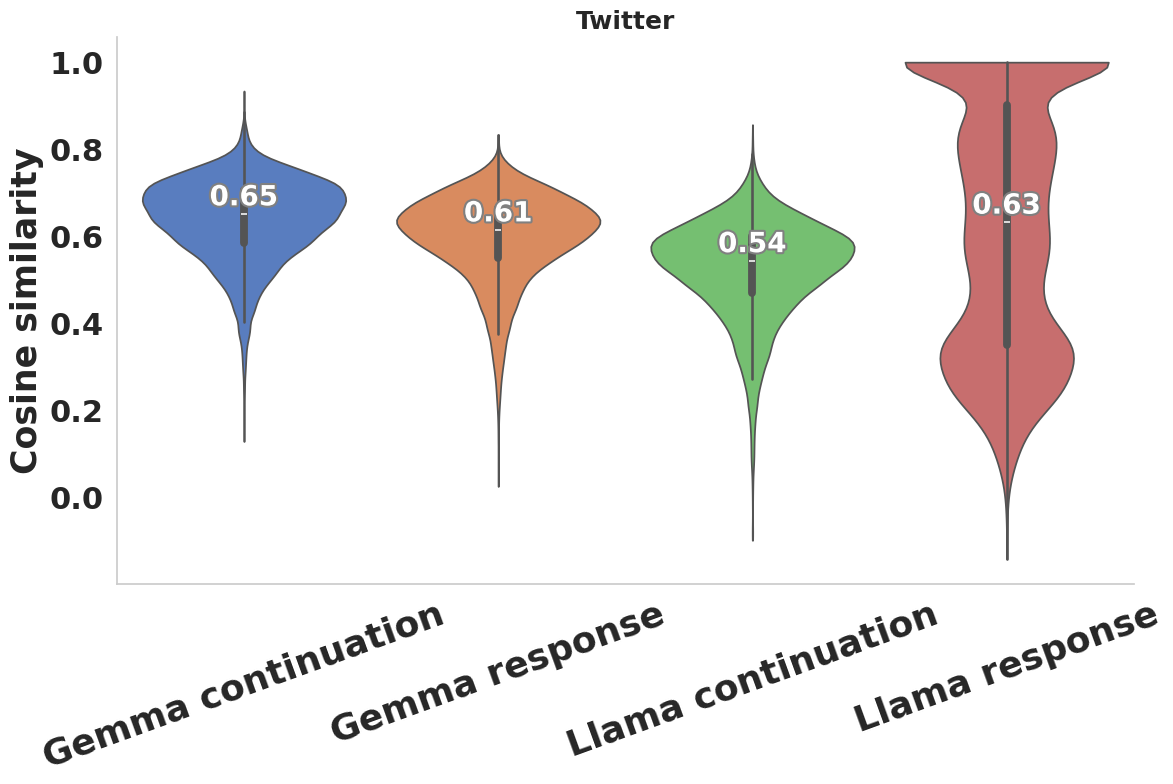

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

df_melted = df2.melt(
    value_vars=['consine[gemma_expand]', 'consine[gemma_response]', 
                'consine[llama_expand]', 'consine[llama_response]'], 
    var_name='Type', 
    value_name='Value'
)
df_melted['Type'] = df_melted['Type'].replace({
    'consine[gemma_expand]': 'Gemma continuation',
    'consine[gemma_response]': 'Gemma response',
    'consine[llama_expand]': 'Llama continuation',
    'consine[llama_response]': 'Llama response'
})


sns.set(style="whitegrid")
medians = df_melted.groupby('Type')['Value'].median()


plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='Type', y='Value', data=df_melted, palette="muted", cut=0)

offset = 0.02  
for i, type_group in enumerate(medians.index):
    median_value = medians[type_group]
    text = ax.text(
        i, median_value + offset, f'{median_value:.2f}',  # position adjust
        horizontalalignment='center', color='white', fontsize=20, 
        fontweight='bold'
    )
    
    text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='gray'),  
        path_effects.Normal()  
    ])
plt.title('Twitter', fontsize=18, fontweight = 'bold')
plt.xlabel('', fontsize=12)
plt.ylabel('Cosine similarity', fontsize=25, fontweight = 'bold')
plt.grid(False)
ax = plt.gca()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(fontsize = 26,rotation=20, fontweight = 'bold')
plt.yticks(fontsize = 22,fontweight = 'bold')
plt.tight_layout()
plt.savefig('new_pic/[Twitter][4task_embedding_cosine_violine]2.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [48]:
# M-W U test
# within groups
print(f"Gemma的续写与回复的cosine similarity:")
Mann_Whitney_U_test(df2['consine[gemma_expand]'].to_list(), df2['consine[gemma_response]'].to_list())
print(f"Llama的续写与回复的cosine similarity:")
Mann_Whitney_U_test(df2['consine[llama_expand]'].to_list(), df2['consine[llama_response]'].to_list())

Gemma的续写与回复的cosine similarity:
U统计量: 93014920.0, P值: 9.742728092554446e-251, 前者整体显著比后者大。
Llama的续写与回复的cosine similarity:
U统计量: 60081284.0, P值: 4.694950281223653e-150, 前者整体显著比后者小。


In [37]:
u_statistic, p_value = mannwhitneyu(df2['consine[llama_expand]'].to_list(), df2['consine[llama_response]'].to_list(), alternative='greater')
print(f"U统计量: {u_statistic}, P值: {p_value}", end=', ')

U统计量: 60081284.0, P值: 1.0, 

In [50]:
# inter groups
print(f"Gemma的续写与Llama的续写cosine similarity:")
Mann_Whitney_U_test(df2['consine[gemma_expand]'].to_list(), df2['consine[llama_expand]'].to_list())
print(f"Gemma的回复与Llama的回复的cosine similarity:")
Mann_Whitney_U_test(df2['consine[gemma_response]'].to_list(), df2['consine[llama_response]'].to_list())

Gemma的续写与Llama的续写cosine similarity:
U统计量: 118641175.0, P值: 0.0, 前者整体显著比后者大。
Gemma的回复与Llama的回复的cosine similarity:
U统计量: 69518835.0, P值: 2.5759460691176395e-19, 前者整体显著比后者小。


In [38]:
u_statistic, p_value = mannwhitneyu(df2['consine[gemma_response]'].to_list(), df2['consine[llama_response]'].to_list(), alternative='greater')
print(f"U统计量: {u_statistic}, P值: {p_value}", end=', ')

U统计量: 69518835.0, P值: 1.0, 

In [74]:
statistics = df2[['consine[gemma_expand]', 'consine[gemma_response]', 
                'consine[llama_expand]', 'consine[llama_response]']].describe()
statistics

consine[gemma_expand]  consine[gemma_response]  consine[llama_expand]  \
count           12200.000000             12200.000000           12200.000000   
mean                0.638330                 0.596591               0.524313   
std                 0.093649                 0.099895               0.112263   
min                 0.129047                 0.025838              -0.097795   
25%                 0.584854                 0.549509               0.468873   
50%                 0.651269                 0.614318               0.543762   
75%                 0.706455                 0.665835               0.599940   
max                 0.933670                 0.833605               0.856386   

       consine[llama_response]  
count             12200.000000  
mean                  0.624748  
std                   0.289307  
min                  -0.140821  
25%                   0.349733  
50%                   0.632225  
75%                   0.900812  
max                   1.000000